*Before going any further, this would not have been possible without the Kaggle community support. Loads of doubts were cleared during discussions and reading public kernels.*

# Melanoma Classification : Model Development

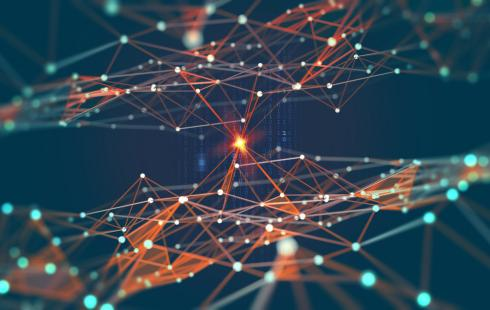

## Notebook III of III

This notebook is the III one in my series of work in this competition. As always shout out to amazing kernel authors present here at kaggle!! I got loads of inspiration from them. I believe this is the best thing about the ML community. The extent of collaboration and guidance one can seek here is inexplicable!!

## Previous works : 
* Dataset preparation(Notebook I) : 
**https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-one**

* Exploratory Data Analysis(Notebook II) : 
**https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-two?scriptVersionId=38737733**

**Please consider upvoting if you find the overall series of notebooks useful! I have tried explaining the steps performed in profound details.**

Thank you! 
Let's begin!!~~

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

/kaggle/input
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/tfrecords
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test
/kaggle/input/siim-isic-melanoma-classification/test


## Let's look at the libraries we need : 

* Numpy : For working on ndarrays. It's a base library in any Machine Learning application.
* Pandas : Handling csvs'. It's dataframe data structure allows us to quickly derieve insights from our csv data.
* Matplotlib, Seaborn and Plotly : Plotting libraries for Python3.
* cv2 : Open source library for Image Processing and Computer Vision.
* Tensorflow : A deep learning framework for designing models and input data pipelines.
* partial : Basically used when there are cases of optional arguments. This keeps the pipeline intact. 
* sklearn : This is for yet another beautifully optimized ML library having off-the-shelf ML algorithms implemented. 
* tqdm : For visualizing progress during a loop or any iteration for that matters.
* gc : Garbage collection. This is for freeing the underlying memory from temporary variables and references.

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import cv2
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
from functools import partial
import sklearn
from tqdm import tqdm_notebook as tqdm
import gc
%matplotlib inline

In [3]:
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import efficientnet.tfkeras as efn

Let's initialize our TPU !!

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [6]:
print('Device:', tpu.master())
print('Number of replicas:', strategy.num_replicas_in_sync)
print("Version of Tensorflow used : ", tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
Version of Tensorflow used :  2.2.0


The directory name of the Kaggle dataset.

In [7]:
!ls /kaggle/input

siim-isic-melanoma-classification


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path("siim-isic-melanoma-classification")
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]
SHAPE = [256, 256]

In [9]:
print("Batch Size = ", BATCH_SIZE)
print("GCS Path = ", GCS_PATH)

Batch Size =  128
GCS Path =  gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c


Upload the updated training and test csv obtained in the EDA notebook. There we filled the missing values and saved them in our custom dataset folder.

**Dataset : https://www.kaggle.com/fireheart7/melanoma-image-insights**

In [10]:
train = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/train.csv"))
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [11]:
test = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/test.csv"))
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [14]:
train_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

In [15]:
image_names = train["image_name"].values + ".jpg"
random_images = [np.random.choice(image_names) for i in range(4)] # Generates a random sample from a given 1-D array
random_images 

['ISIC_8623233.jpg',
 'ISIC_7733890.jpg',
 'ISIC_7717610.jpg',
 'ISIC_8967329.jpg']

## Tensorflow Records : 

Many folks don't really understand this! So let's have some insight before we actually dive into creating our model.

**What is Tensorflow Record?**

It's Tensorflow's binary storage format for your data. 

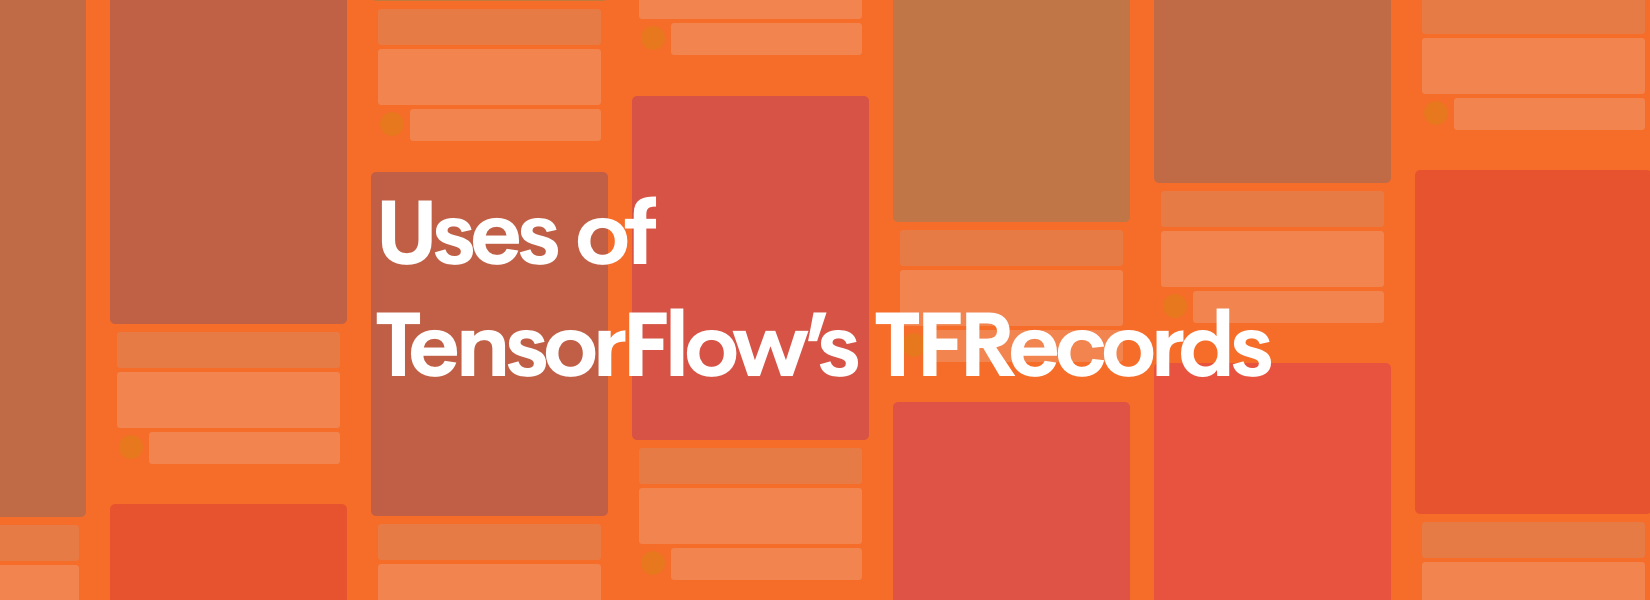

**Okay, so what's the endgame? Aren't JPEG, PNG also storage formats? What makes this one special ?**

Well, short answer : It's Google's.
Ummm.. a little longer answer would be that binary storage data takes up relatively low space on your disk, and hence it takes less time to copy and can be read much more efficiently! Moreover, the *tensorflow* framework is optimized to handle tfrecords amazingly well. 

The datasets that are too large to be stored fully in memory, this is an advantage as only the data that is required at the time (e.g. a batch) is loaded from disk and then processed. 

Another major advantage of TFRecords is that it is possible to store sequence data — for instance, a time series or word encodings — in a way that allows for very efficient and (from a coding perspective) convenient import of this type of data.

*In a nutshell, it's cool !*

## TFRecord = Array of Examples : 

A TFRecord file contains an array of `Examples`. `Example` is a data structure for representing a record, like an observation in a training or test dataset. A record is represented as a set of features, each of which has a name and can be an array of bytes, floats, or 64-bit integers. 

To summarize:

* An Example contains Features.
* Features is a mapping from the feature names stored as strings to Features.

These relations are defined in `example.proto` and `feature.proto` in the TensorFlow's source code, along with extensive comments. As the extension `.proto` suggests, these definitions are based on `protocol buffers`.

## Why Protocol Buffers?

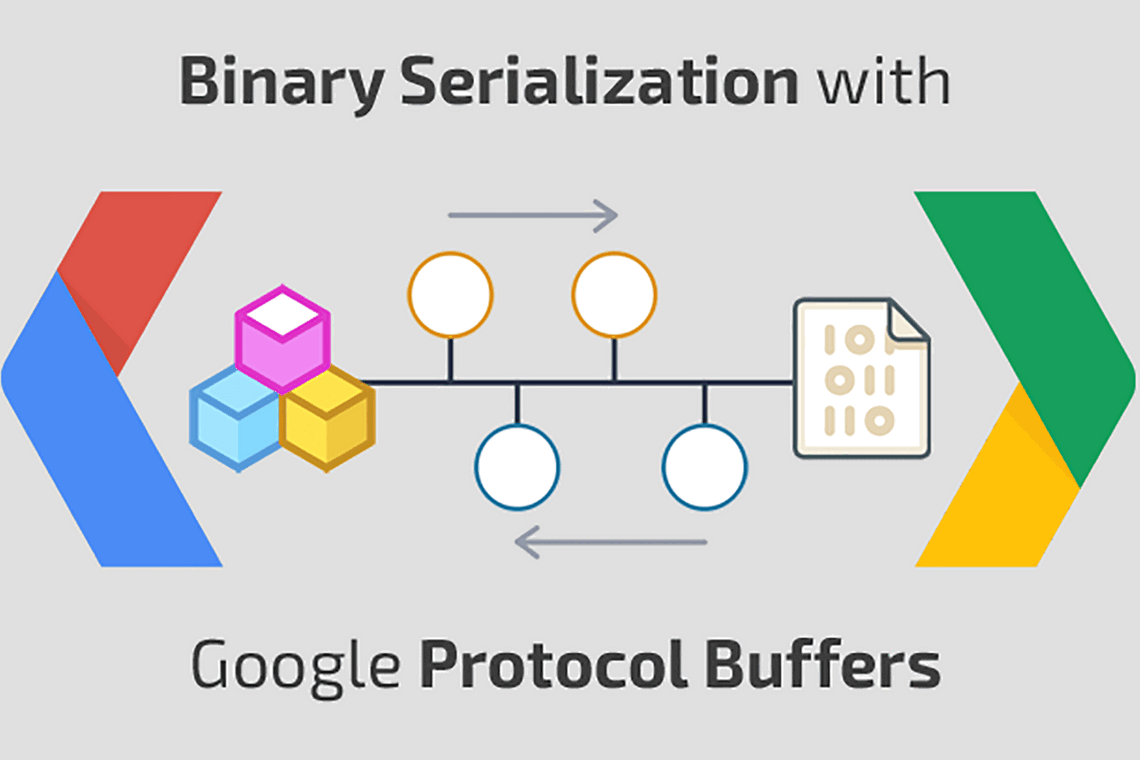 

Google’s Protocol buffers are a serialization scheme for structured data. In other words, protocol buffers are used for serializing structured data into a byte array, so that they can be sent over the network or stored as a file. In this sense, it is similar to JSON, XML.

**Protocol buffers can offer a lot faster processing speed compared to text-based formats like JSON or XML.**

In [16]:
from sklearn.model_selection import train_test_split 
training_files, validation_files = train_test_split(tf.io.gfile.glob(GCS_PATH + "/tfrecords/train*.tfrec"),
                                                   test_size = 0.1, random_state = 42)

testing_files = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")

print("Number of training files = ", len(training_files))
print("Number of validation files = ", len(validation_files))
print("Number of test files = ", len(testing_files))

Number of training files =  14
Number of validation files =  2
Number of test files =  16


In [17]:
def decode_image(image) : 
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

We observe our training_files object stores all tfrecord files. Let's pick one to analyze. 

In [18]:
training_files

['gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train05-2071.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train14-2071.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train13-2071.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train11-2071.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train08-2071.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train09-2071.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train02-2071.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train15-2061.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train04-2071.tfrec',
 'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train07-2071.tfrec',
 'gs://kds

In [19]:
sample_picked = training_files[0]
sample_picked

'gs://kds-5f7102dbc18184848f20665376a3338b4c1063b024f1c352b142999c/tfrecords/train05-2071.tfrec'

A TFRecord file can be read using **tf.data.TFRecordDataset** class.

In [20]:
file = tf.data.TFRecordDataset(sample_picked)
file

<TFRecordDatasetV2 shapes: (), types: tf.string>

* At this point the dataset contains serialized **tf.train.Example** messages. When iterated over it returns these as scalar string tensors. 

*This means that it is composed of a tensors and we need to parse it in order to make some meaning of it. For that very purpose it becomes mandatory to define a feature_description as tensorflow TFRecord datasets use Tensorflow's graph execution instead of Eager execution**. 

Basically : 

* Eager execution is what has been done so far. You write a statement and execute it. The results appear instantaneously. This imperative way of programming is inspired from Python3.

* On the other hand, Graph execution is another way of defining control flow where we construct a structure in which we define how a tensor flows( hence the name tensorflow, I guess). This means say at the first node there has to be addition of two tensors, at the second rescaling, third divison and in the final node an activation function is there to return the final answer. 

* Graph execution is extremely useful in areas where Python interpreter is absent like in Android applications, and so on. Here, due to computational graphs, tensorflow models can still be deployed. This makes tensorflow an amazing tool for model deployment. However, that's a story for another day.

In [21]:
feature_description = {"image" : tf.io.FixedLenFeature([], tf.string), 
                      "target" : tf.io.FixedLenFeature([], tf.int64)}

In [22]:
def parse_function(example) : 
    # The example supplied is parsed based on the feature_description above.
    return tf.io.parse_single_example(example, feature_description)

In [23]:
parsed_dataset = file.map(parse_function)
parsed_dataset

<MapDataset shapes: {image: (), target: ()}, types: {image: tf.string, target: tf.int64}>

In [24]:
def read_tfrecord(example, labeled) : 
    if labeled == True : 
        tfrecord_format = {"image" : tf.io.FixedLenFeature([], tf.string),
                           "target" : tf.io.FixedLenFeature([], tf.int64)}
    else:
        tfrecord_format = {"image" : tf.io.FixedLenFeature([], tf.string),
                          "image_name" : tf.io.FixedLenFeature([], tf.string)}
    
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled == True : 
        label = tf.cast(example["target"], tf.int32)
        return image, label
    else:
        image_name = example["image_name"]
        return image, image_name     

Some key modules used :

* **tf.data.Options()** : An Options object can be, for instance, used to control which graph optimizations to apply. 

* **.experiemental_deterministic** : `experiemntal_deterministic` refers to whether the outputs need to be produced in deterministic order. If None, defaults to True. Here, the data is unordered, hence we don't need to process it in an order which may slow down our speed. 

* **TFRecordDataset** : A Dataset comprising records from one or more TFRecord files.

* **num_parallel_reads** argument in TFRecordDataset : A tf.int64 scalar representing the number of files to read in parallel.

TFRecord files of training and testing are mixed. Therefore we don't know whether the file being input has a label of malignant/benign associated with it or not! Hence, we will supply both example and label to it, and simply set the label to False in the function call stack; in case label is absent. 

For test images, we will return the image name instead of the label.

Note below we have a condition for disabling the order. This will come in handy, as for training and validation purposes, we don't need to take care of the order. However, for test images we have to submit the predictions and they have to be in order. Hence, for them `experimental_deterministic will remain true`. The role of `experimental_deterministic` setting is to `disable data order reinforcement.`

More detail can be found at : **https://www.kaggle.com/docs/tpu**

In [25]:
def load_dataset(filenames, labeled, ordered):
    ignore_order = tf.data.Options()
    if ordered == False: # dataset is unordered, so we ignore the order to load data quickly.
        ignore_order.experimental_deterministic = False # This disables the order and enhances the speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) 
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [26]:
def image_augmentation(image, label) :     
    image = tf.image.resize(image, SHAPE)
    image = tf.image.random_flip_left_right(image)
    return image, label

# Load The Datasets : 

* **map( )** : This transformation applies map_func to each element of this dataset, and returns a new dataset containing the transformed elements

* **repeat( )** : Repeats this dataset so each original value is seen count times.

* **shuffle( )** : Randomly shuffles the elements of this dataset.

* **batch( )** : Combines consecutive elements of this dataset into batches.

* **prefetch( )** : Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. prefetch( ) doesn’t allow CPU stand idle. When model is training prefetch continue prepare data while GPU is busy.

* **cache( )** : The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data. When caching to a file, the cached data will persist across runs. Even the first iteration through the data will read from the cache file. 

In [27]:
def get_training_dataset() : 
    dataset = load_dataset(training_files, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [28]:
def get_validation_dataset() : 
    dataset = load_dataset(validation_files, labeled = True, ordered = False)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [29]:
def get_test_dataset() : 
    dataset = load_dataset(testing_files, labeled = False, ordered = True)
    dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

In [30]:
training_dataset = get_training_dataset()

In [31]:
validation_dataset = get_validation_dataset()

In [32]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(training_files)
num_validation_images = count_data_items(validation_files)
num_testing_images = count_data_items(testing_files)

STEPS_PER_EPOCH_TRAIN = num_training_images // BATCH_SIZE
STEPS_PER_EPOCH_VAL = num_validation_images // BATCH_SIZE

print("Number of Training Images = ", num_training_images)
print("Number of Validation Images = ", num_validation_images)
print("Number of Testing Images = ", num_testing_images)
print("\n")
print("Numer of steps per epoch in Train = ", STEPS_PER_EPOCH_TRAIN)
print("Numer of steps per epoch in Validation = ", STEPS_PER_EPOCH_VAL)

Number of Training Images =  28984
Number of Validation Images =  4142
Number of Testing Images =  10982


Numer of steps per epoch in Train =  226
Numer of steps per epoch in Validation =  32


In [33]:
image_batch, label_batch = next(iter(training_dataset))

In [34]:
def show_batch(image_batch, label_batch) :
    plt.figure(figsize = (20, 20))
    for n in range(8) : 
        ax = plt.subplot(2,4,n+1)
        plt.imshow(image_batch[n], cmap = "gray")
        if label_batch[n] == 0 : 
            plt.title("BENIGN")
        else:
            plt.title("MALIGNANT")
    plt.grid(False)
    plt.tight_layout()       

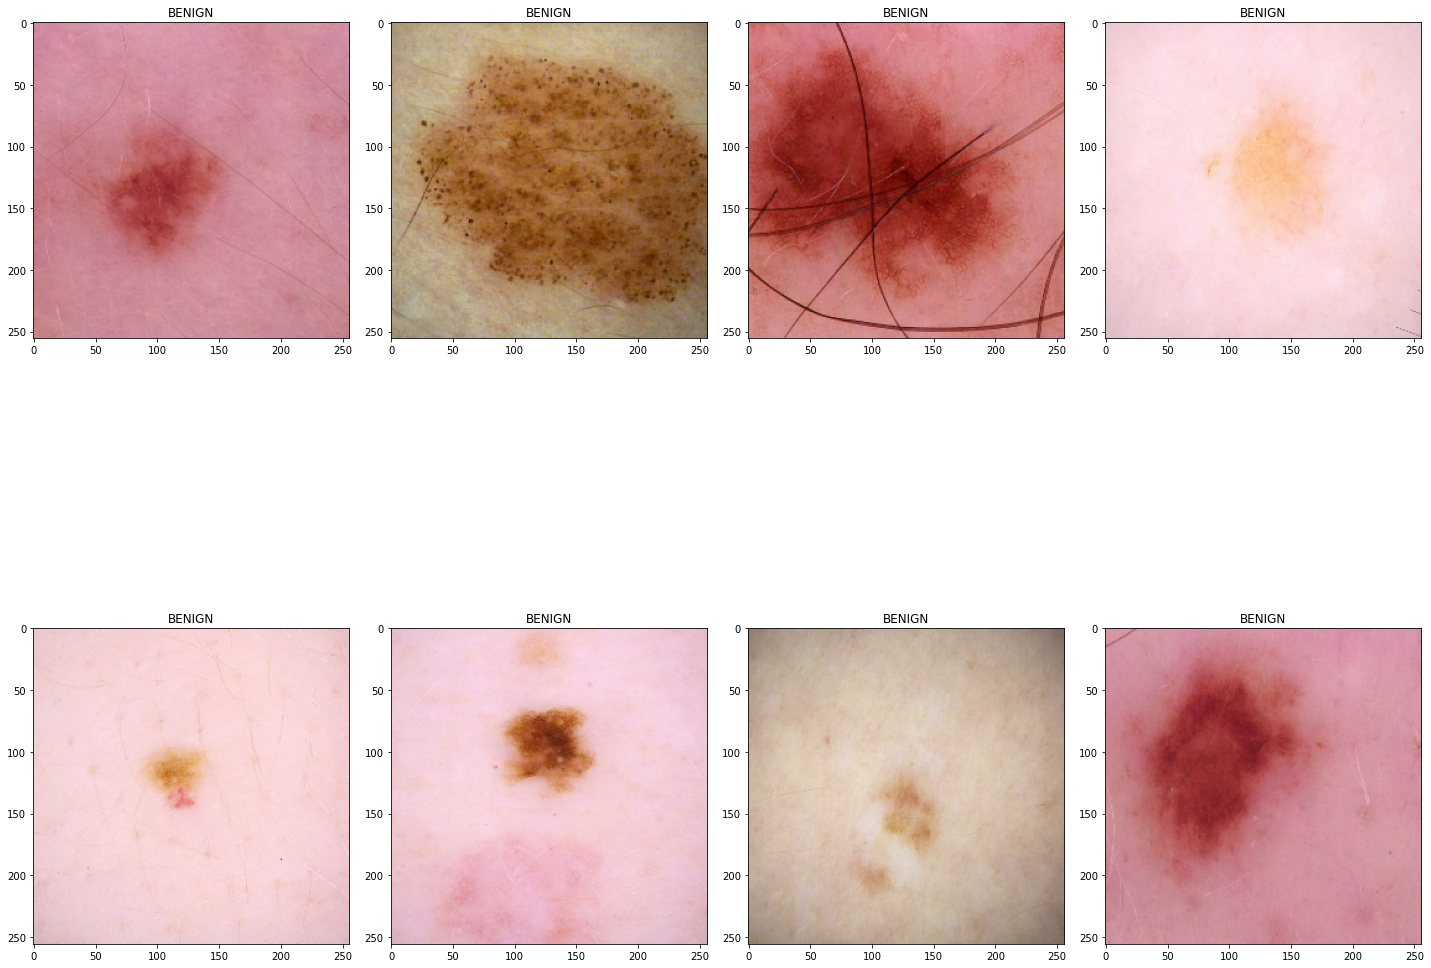

In [35]:
show_batch(image_batch.numpy(), label_batch.numpy())

Let's free up some memory

In [36]:
del image_batch
del label_batch
gc.collect()

17724

# Model Construction : 

## Malignant VS Benign Imbalance Analysis 

In [37]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0 ])
total = len(train) 

print("Malignant Cases in Train Data = ", malignant)
print("Benign Cases In Train Dataset = ",benign)
print("Total Cases In Train Dataset = ",total)
print("Ratio of Malignant to Benign = ",malignant/benign)

Malignant Cases in Train Data =  584
Benign Cases In Train Dataset =  32542
Total Cases In Train Dataset =  33126
Ratio of Malignant to Benign =  0.017946038965029807


## Class Weights Initialization : 

We saw earlier that malignant cases happen to be far less than the benign ones. Hence, we ought to set relatively heavy weights for malignant cases compared to the benign ones. This will encourage the model to pay more attention to malignant ones.

`According to official Tensorflow documentation : `

*Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class*.

In [38]:
weight_malignant = (total/malignant)/2.0
weight_benign = (total/benign)/2.0

class_weight = {0 : weight_benign , 1 : weight_malignant}

print("Weight for benign cases = ", class_weight[0])
print("Weight for malignant cases = ", class_weight[1])

Weight for benign cases =  0.5089730194825149
Weight for malignant cases =  28.361301369863014


In [39]:
config = {
    "shape" : 256 ,
    "optimizer" : "adam",
    "epochs" : 400,
    "training_steps_per_epoch" : STEPS_PER_EPOCH_TRAIN,
    "validation_steps_per_epoch" : STEPS_PER_EPOCH_VAL,
    "loss" : "binary_crossentropy",
    
}

In [40]:
def custom_operation(input_tensor) : 
    return input_tensor

## Bias Initialization : 

Since the dataset is heavily imbalanced, we may want to assign different weights to different classes. Setting an initial bias is important in such cases.

In [41]:
def ensemble_model() : 
    bias = np.log(malignant/benign)
    bias = tf.keras.initializers.Constant(bias)
    model_input = tf.keras.layers.Input(shape = (config["shape"], config["shape"], 3) , name = "input_tensor_shape")
    lambda_layer = tf.keras.layers.Lambda(custom_operation)(model_input)
    outputs = []
    x = efn.EfficientNetB3(include_top = False, weights='noisy-student', input_shape = (config["shape"], 
                                                                                       config["shape"], 3),
                          pooling = "avg")(lambda_layer)
    x = tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)(x)
    outputs.append(x)
    
    x = efn.EfficientNetB4(include_top = False, weights = 'noisy-student', input_shape = (config["shape"],
                                                                                         config["shape"], 3),
                          pooling = "avg")(lambda_layer)
    x = tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)(x)
    outputs.append(x)
    
    x = efn.EfficientNetB5(include_top = False, weights = 'noisy-student', input_shape = (config["shape"],
                                                                                         config["shape"], 3),
                          pooling = "avg")(lambda_layer)
    x = tf.keras.layers.Dense(1, activation = "sigmoid", bias_initializer = bias)(x)
    outputs.append(x)
    
    model = tf.keras.Model(model_input, outputs, name = "Ensemble")
    model.summary()
    return model

## Setting Evaluation Metric: 

*This is taken from Amy Jang's notebook as mentioned earlier.*

*Notebook : https://www.kaggle.com/amyjang/tensorflow-transfer-learning-melanoma*

When we compile our model, we do not want our metric to be accuracy. If we run the model, with an accuracy metric, it will give us false confidence in our model. If we look at the dataset, we see that 98% of the images are classifed as benign, 0. Now, if accuracy was the sole determinant of our model, a model that always outputs 0 will achieve a high accuracy although the model is not good.

The competition scores the model by finding the area under the ROC curve, which is why our metric will be set to keras.metrics.AUC.

In [42]:
def compile_model(config) : 
    with strategy.scope() : 
        model = ensemble_model()
    
    with strategy.scope() : 
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-2),
                      loss = [config["loss"],
                              config["loss"],
                              config["loss"]],
                     metrics = [tf.keras.metrics.AUC(name = "auc")])
        return model

## Defining CallBacks : 

A callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference. Callbacks are useful to get a view on internal states and statistics of the model during training.

This can be used to stop predictions when there is no change in the desired metric over a certain epoch range. This is amazingly useful in order to avoid `overfitting`. 

Here we use : 

* ModelCheckPoint : Callback to save the Keras model or model weights at some frequency.
* EarlyStopping : Stop training when a monitored metric has stopped improving.

In [43]:
def callbacks() : 
        
    callback_early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20, verbose = 1, restore_best_weights = True)
    callback_lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "auc", factor = 0.1, patience = 20,
                                                              verbose = 1, min_lr = 1e-7)
    callback_checkpoint = tf.keras.callbacks.ModelCheckpoint("melanoma-weights.h5", save_weights_only = True,
                                                            monitor = "auc", mode = "max", save_best_only = True)
    callbacks = [callback_early_stopping, callback_lr_reduce, callback_checkpoint]
    return callbacks

In [44]:
model = compile_model(config)

115261440/115255328 [==============================] - 4s 0us/step
Model: "Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tensor_shape (InputLayer) [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_tensor_shape[0][0]         
__________________________________________________________________________________________________
efficientnet-b3 (Model)         (None, 1536)         10783528    lambda[0][0]                     
__________________________________________________________________________________________________
efficientnet-b4 (Model)         (None, 1792)         17673816    lambda[0][0]                     
________________________

In [45]:
history = model.fit(training_dataset, epochs = config["epochs"],
                    steps_per_epoch = config["training_steps_per_epoch"],
                    validation_data = validation_dataset,
                    validation_steps = config["validation_steps_per_epoch"], 
                   callbacks = callbacks(), class_weight = class_weight)

Epoch 1/400
226/226 [==============================] - 181s 799ms/step - dense_1_loss: 0.9441 - dense_loss: 0.7790 - dense_auc: 0.5920 - dense_2_auc: 0.5271 - dense_2_loss: 0.8960 - loss: 2.6191 - dense_1_auc: 0.5184 - val_dense_1_loss: 1.2914 - val_dense_loss: 5.8595 - val_dense_auc: 0.6680 - val_dense_2_auc: 0.4107 - val_dense_2_loss: 5.0104 - val_loss: 12.1613 - val_dense_1_auc: 0.5168 - lr: 0.0100
Epoch 2/400
226/226 [==============================] - 122s 538ms/step - dense_1_loss: 0.7037 - dense_loss: 0.6643 - dense_auc: 0.6797 - dense_2_auc: 0.5919 - dense_2_loss: 0.7224 - loss: 2.0905 - dense_1_auc: 0.6210 - val_dense_1_loss: 0.1739 - val_dense_loss: 2.7263 - val_dense_auc: 0.6798 - val_dense_2_auc: 0.4747 - val_dense_2_loss: 390.0526 - val_loss: 392.9528 - val_dense_1_auc: 0.6256 - lr: 0.0100
Epoch 3/400
226/226 [==============================] - 131s 579ms/step - dense_1_loss: 0.6247 - dense_loss: 0.5982 - dense_auc: 0.7439 - dense_2_auc: 0.6721 - dense_2_loss: 0.6679 - loss:

Let's observe the number of epochs our model ran for before callbacks stopped the execution due to no further significant improvement in validation_accuracy.

In [46]:
epochs_it_ran_for = len(history.history['dense_4_loss'])
print("Model trained for", epochs_it_ran_for,"epochs")

KeyError: 'dense_4_loss'

In [47]:
training_loss = np.add(np.array(history.history["dense_4_loss"]), np.array(history.history["dense_5_loss"]), 
             np.array(history.history["dense_6_loss"]))
mean_training_loss = training_loss / epochs_it_ran_for


val_loss = np.add(np.array(history.history["val_dense_4_loss"]), np.array(history.history["val_dense_5_loss"]), 
             np.array(history.history["val_dense_6_loss"]))
mean_val_loss = val_loss / epochs_it_ran_for


training_accuracy = np.add(np.array(history.history["dense_4_auc"]), np.array(history.history["dense_5_auc"]), 
             np.array(history.history["dense_6_auc"]))
mean_training_accuracy = training_accuracy / epochs_it_ran_for


val_accuracy = np.add(np.array(history.history["val_dense_4_auc"]), np.array(history.history["val_dense_5_auc"]), 
             np.array(history.history["val_dense_6_auc"]))
mean_val_accuracy = val_accuracy / epochs_it_ran_for


X = np.arange(0,n_epochs_it_ran_for,1)
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, mean_training_loss, label = "Mean Training Loss")
plt.plot(X, mean_val_loss, label = "Mean Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(X, mean_training_accuracy, label = "Mean Training Accuracy")
plt.plot(X, mean_val_accuracy, label = "Mean Validation Accuracy")

#plt.plot(X, history.history["val_auc"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

KeyError: 'dense_4_loss'

Due to callbacks, best weights are automatically restored!

In [48]:
testing_dataset = get_test_dataset()
testing_dataset_images = testing_dataset.map(lambda image, image_name : image)
testing_image_names = testing_dataset.map(lambda image, image_name : image_name)

In [49]:
resulting_probabilities = model.predict(testing_dataset_images, verbose = 1)

86/86 [==============================] - 31s 361ms/step


In [50]:
type(resulting_probabilities[0])

numpy.ndarray

In [51]:
sum_resulting_probabilities = np.add(resulting_probabilities[0], resulting_probabilities[1], resulting_probabilities[2])
len(sum_resulting_probabilities)

10982

In [52]:
sum_resulting_probabilities

array([[0.26631463],
       [0.5433886 ],
       [0.16780043],
       ...,
       [0.82146156],
       [0.6238674 ],
       [0.45557967]], dtype=float32)

In [53]:
mean_resulting_probabilities = sum_resulting_probabilities / 3
mean_resulting_probabilities

array([[0.08877154],
       [0.18112953],
       [0.05593348],
       ...,
       [0.27382052],
       [0.20795579],
       [0.1518599 ]], dtype=float32)

In [54]:
sample_submission_file = pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
sample_submission_file.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [55]:
del sample_submission_file["target"]
sample_submission_file.head()

,image_name
0,ISIC_0052060
1,ISIC_0052349
2,ISIC_0058510
3,ISIC_0073313
4,ISIC_0073502


In [56]:
testing_image_names

<MapDataset shapes: (None,), types: tf.string>

In [57]:
testing_image_names = np.concatenate([x for x in testing_image_names], axis=0)
testing_image_names = np.array(testing_image_names)

In [58]:
decoded_test_names = []
for names in testing_image_names : 
    names = names.decode('utf-8')
    decoded_test_names.append(names)
decoded_test_names = np.array(decoded_test_names)
del testing_image_names

In [59]:
len(decoded_test_names), type(decoded_test_names), decoded_test_names.shape

(10982, numpy.ndarray, (10982,))

In [60]:
decoded_test_names

array(['ISIC_6381819', 'ISIC_5583376', 'ISIC_6408546', ...,
       'ISIC_8285611', 'ISIC_2076526', 'ISIC_8959686'], dtype='<U12')

In [61]:
testing_image_names = pd.DataFrame(decoded_test_names, columns=["image_name"])
testing_image_names.head()

,image_name
0,ISIC_6381819
1,ISIC_5583376
2,ISIC_6408546
3,ISIC_6932354
4,ISIC_8191278


In [62]:
pred_dataframe = pd.DataFrame({"image_name" : decoded_test_names, 
                               "target" : np.concatenate(mean_resulting_probabilities)})
pred_dataframe

,image_name,target
0,ISIC_6381819,0.088772
1,ISIC_5583376,0.181130
2,ISIC_6408546,0.055933
3,ISIC_6932354,0.129789
4,ISIC_8191278,0.022777
...,...,...
10977,ISIC_1581247,0.042747
10978,ISIC_8432732,0.121714
10979,ISIC_8285611,0.273821
10980,ISIC_2076526,0.207956


In [63]:
sample_submission_file = sample_submission_file.merge(pred_dataframe, on = "image_name")
sample_submission_file.to_csv("submission.csv", index = False)
sample_submission_file.head()

,image_name,target
0,ISIC_0052060,0.050966
1,ISIC_0052349,0.060284
2,ISIC_0058510,0.038420
3,ISIC_0073313,0.060850
4,ISIC_0073502,0.047749


## The journey continues!!

The pre-processing we did earlier, I'll soon share the dataset of denoised, histogram equalized images. Then using the approach here in this notebook, we will use tf.data API to directly train on them!!

Stay Tuned!~~

In the meantime, you can view my other works in the SIIM ISIC Melanoma Challenge : 

* **https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-one**
* **https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-two**